<a href="https://www.kaggle.com/code/jojofarhan/resturent-recomendation-foodpandadataset?scriptVersionId=264150364" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Resturant Recomendation By Food Review DataSet**

This project builds a **restaurant recommendation system** using food review data from Bangladesh.  
It leverages **NLP, sentiment analysis, machine learning, and deep learning** techniques to recommend restaurants based on customer reviews.

---

## Features
- Load and preprocess restaurant review dataset  
- Perform **sentiment analysis** on reviews using Hugging Face Transformers  
- Calculate **mean restaurant ratings** (scaled between 1–5)  
- Visualize:
  - Distribution of restaurant ratings  
  - Top 10 rated restaurants  
  - Sentiment distribution across reviews  
  - Most famous restaurant chains  
  - Word frequency distributions from reviews  
- Build a **TF-IDF & Cosine Similarity based recommendation system**  
- Provide two types of recommendations:
  1. **Similar restaurants** (based on review similarity)  
  2. **Location-based recommendations** (similar restaurants in the same city)

---

## Tech Stack
- **Python Libraries**:  
  - Data Handling: `numpy`, `pandas`, `scipy`  
  - Visualization: `matplotlib`, `seaborn`  
  - NLP: `nltk`, `transformers` (Hugging Face)  
  - Machine Learning: `scikit-learn`  
  - Deep Learning: `tensorflow`, `keras`  
  - Utilities: `tqdm`, `pickle`, `gc`, `warnings`
- **Sentiment Analysis Model**: Hugging Face `pipeline("sentiment-analysis")`  
- **Platform**: Google Colab (with Google Drive integration)

---

## Dataset
- **File**: `Food Review Dataset of Bangladesh.xlsx`  
- **Sheet**: `Sheet1`  
- Columns used:  
  - `restaurant`, `city`, `preprocessed_text`, `ratings_int`  
- Preprocessing includes:
  - Dropping unnecessary columns (`reviewer_name`, `ratings`, `review_text`, etc.)  
  - Removing nulls & duplicates  
  - Sampling ~8300 reviews  

---

## Visualizations
- Restaurant rating distribution  
- Top 10 restaurants  
- Sentiment distribution pie chart  
- Most famous restaurants (chains)  
- Word couple frequency plots

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, string, re, random, gc, pickle, math,warnings
from tqdm.keras import TqdmCallback
from tqdm import tqdm
from scipy.sparse import csr_matrix

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK
from nltk.corpus import stopwords

# Transformers
import transformers
from transformers import pipeline

# Sklearn
from sklearn.model_selection import *
from sklearn.feature_extraction import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.utils import *
from sklearn.pipeline import *
from sklearn.compose import *
from sklearn.metrics.pairwise import linear_kernel,laplacian_kernel


# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import *
from tensorflow.keras.utils import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import *
from tensorflow.keras.callbacks import *

# Setting
pd.set_option('max_colwidth',None)
seed = random.randint(1,100)
warnings.simplefilter('ignore')
sentiment_pipeline = pipeline("sentiment-analysis")

2025-09-26 12:51:14.417146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758891074.710282      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758891074.799907      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


In [2]:
import pandas as pd

XLSX = '/kaggle/input/food-review-dataset-of-bangladesh/Food Review Dataset of Bangladesh.xlsx'
pd.ExcelFile(XLSX).sheet_names


['Sheet1']

## **Load The Data And Process It**

In [3]:
XLSX = '/kaggle/input/food-review-dataset-of-bangladesh/Food Review Dataset of Bangladesh.xlsx'
Sheet = '/kaggle/input/food-review-dataset-of-bangladesh/'

# Load
raw = pd.read_excel(XLSX, sheet_name='Sheet1')

# Drop Column(s)
unwanted = ['reviewer_name','ratings','review_text','scraper','text','time']
df = raw.drop(unwanted,axis=1,inplace=False)

# Sampling 'n' samples
n = 8300
df = df.sample(n)

# Drop Nulls & Duplicates
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Reset Index
df.reset_index(drop=True,inplace=True)

# View
df.head()

,ratings_int,restaurant,city,preprocessed_text
0,3,Chillox - Lalbagh,Dhaka,ordered a burger and a red velvet the burger was good but the cake wasn t
1,1,Arrow Spoon,Rajshahi,there is no more mc restaurant in rajshahi than them bad food rupees fried rice combo shit
2,1,Bismillah Hotel & Restaurant - Dhanmondi,Dhaka,very very bad resturent they deliver me diffrent food what was not in my order and aslo days old bad smell food i order from hospital and they deliver food pm now i can t order anything
3,2,Prince Burger,Dhaka,i told you not to give too much sauce in burger
4,3,Best Fried Chicken (BFC) - Meher Plaza,Dhaka,ordered masala french fries but received them


## **Sentiment Analysis**

In [4]:
sentiments = []

for t in tqdm(df['preprocessed_text'].tolist()):
    sentiment_ouput = sentiment_pipeline(t)
    for so in sentiment_ouput:
        sentiments.append(so['label'].title())

# Add New Column
df['sentiment'] = sentiments


# View
df.head()

100%|██████████| 8138/8138 [04:35<00:00, 29.51it/s]


,ratings_int,restaurant,city,preprocessed_text,sentiment
0,3,Chillox - Lalbagh,Dhaka,ordered a burger and a red velvet the burger was good but the cake wasn t,Negative
1,1,Arrow Spoon,Rajshahi,there is no more mc restaurant in rajshahi than them bad food rupees fried rice combo shit,Negative
2,1,Bismillah Hotel & Restaurant - Dhanmondi,Dhaka,very very bad resturent they deliver me diffrent food what was not in my order and aslo days old bad smell food i order from hospital and they deliver food pm now i can t order anything,Negative
3,2,Prince Burger,Dhaka,i told you not to give too much sauce in burger,Negative
4,3,Best Fried Chicken (BFC) - Meher Plaza,Dhaka,ordered masala french fries but received them,Negative


**Mean Rating Calculaton**

In [5]:
restaurants = list(df['restaurant'].unique())
df['mean_rating'] = 0

for i in range(len(restaurants)):
    df['mean_rating'][df['restaurant'] == restaurants[i]] = df['ratings_int'][df['restaurant'] == restaurants[i]].mean()

#Scaling the mean rating values
scaler = MinMaxScaler(feature_range = (1,5))
df[['mean_rating']] = scaler.fit_transform(df[['mean_rating']]).round(2)

# View
df.head()

,ratings_int,restaurant,city,preprocessed_text,sentiment,mean_rating
0,3,Chillox - Lalbagh,Dhaka,ordered a burger and a red velvet the burger was good but the cake wasn t,Negative,2.91
1,1,Arrow Spoon,Rajshahi,there is no more mc restaurant in rajshahi than them bad food rupees fried rice combo shit,Negative,2.56
2,1,Bismillah Hotel & Restaurant - Dhanmondi,Dhaka,very very bad resturent they deliver me diffrent food what was not in my order and aslo days old bad smell food i order from hospital and they deliver food pm now i can t order anything,Negative,1.77
3,2,Prince Burger,Dhaka,i told you not to give too much sauce in burger,Negative,2.92
4,3,Best Fried Chicken (BFC) - Meher Plaza,Dhaka,ordered masala french fries but received them,Negative,2.91


## Distribution Of Resturant Rating

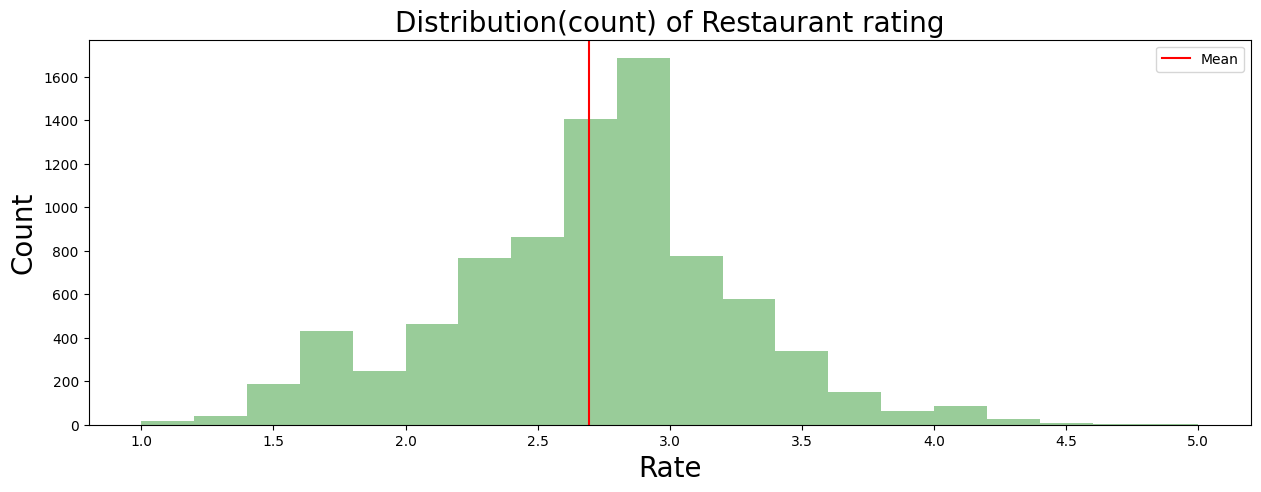

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.distplot(df.mean_rating,kde=False,color = 'g',ax =ax,bins=20);
ax.axvline(df.mean_rating.mean(), 0, 1, color='r', label='Mean')
ax.legend();
ax.set_ylabel('Count',size=20)
ax.set_xlabel('Rate',size=20)
ax.set_title('Distribution(count) of Restaurant rating',size=20);

## Top 10 Resturant List

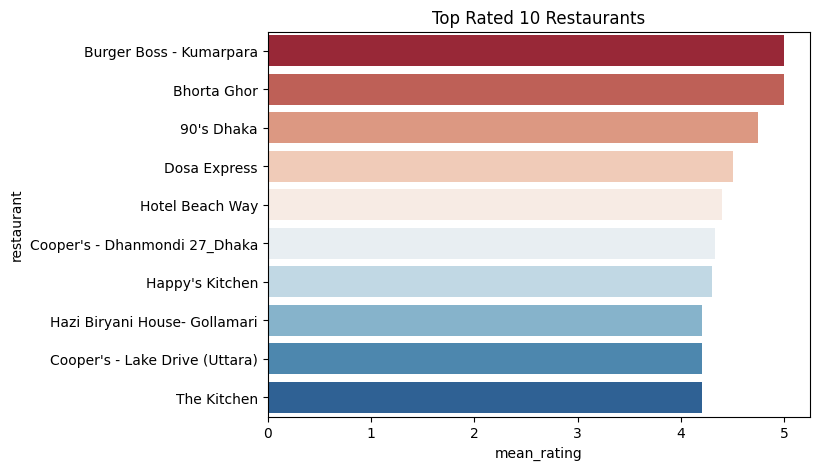

In [7]:
df_rating = df.drop_duplicates(subset='restaurant')
df_rating = df_rating.sort_values(by='mean_rating', ascending=False).head(10)
plt.figure(figsize=(7,5))
sns.barplot(data=df_rating, x='mean_rating', y='restaurant', palette='RdBu')
plt.title('Top Rated 10 Restaurants');

## **Sentiment Distribution**

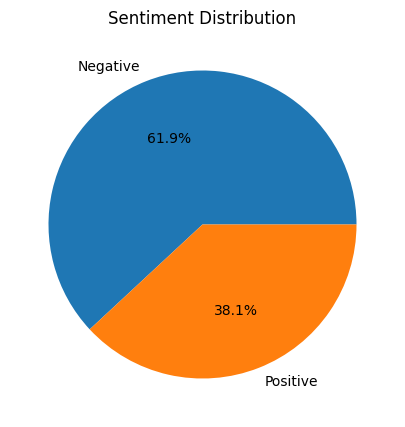

In [8]:
df_sentiment = pd.DataFrame(df.groupby('sentiment').size(),columns=['Count'])
plt.figure(figsize=(7,5))
plt.pie(df_sentiment['Count'], labels=df_sentiment.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.show()

## Most Famous Resturant

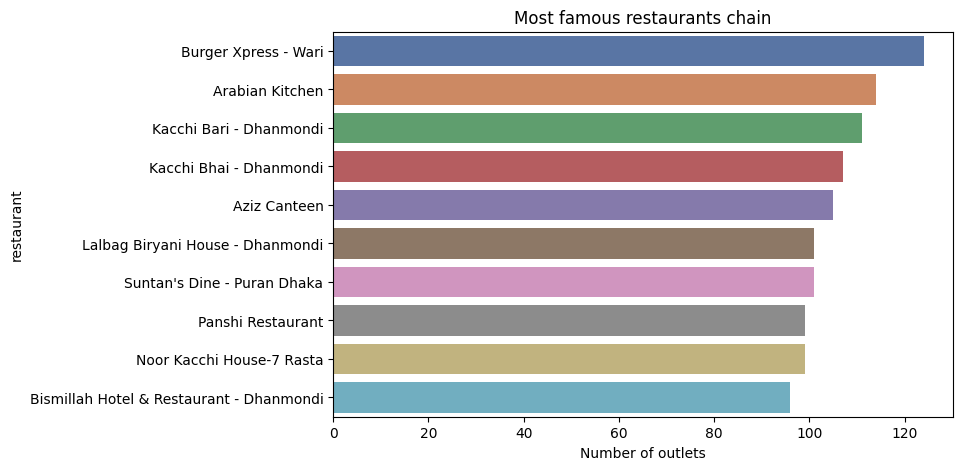

In [9]:
plt.figure(figsize=(8,5))
#chains=df['restaurant'].value_counts()[:10]
chains = pd.DataFrame(df.groupby(['restaurant','city']).size().sort_values(ascending=False),columns=['Count'])[:10]
sns.barplot(x=chains['Count'],y=chains.index.get_level_values("restaurant"),palette='deep')
plt.title("Most famous restaurants chain")
plt.xlabel("Number of outlets")
plt.show()

### **Testing Sentiments**

In [10]:
df.sample(5)

,ratings_int,restaurant,city,preprocessed_text,sentiment,mean_rating
2479,4,Hungry Foodies,Comilla,but it was good don t put onion on pizza that s what everyone says,Negative,3.40
5897,5,KFC_Chittagong,Chittagong,i ordered the mayonnaise course but gave the tomato sauce,Negative,4.00
1070,2,Best Fried Chicken (BFC) - Keari Plaza,Dhaka,poor packaging caused the coleslaw to spill everywhere the soft drink was warm and fries are too small,Negative,2.36
4825,1,Bismillah Hotel & Restaurant - Dhanmondi,Dhaka,gives rotten khichuri,Negative,1.77
6138,1,Cafe Tawa,Dhaka,very bad they never send leg pic only send broken chicken,Negative,2.48


## **Word Frequency Distributions**

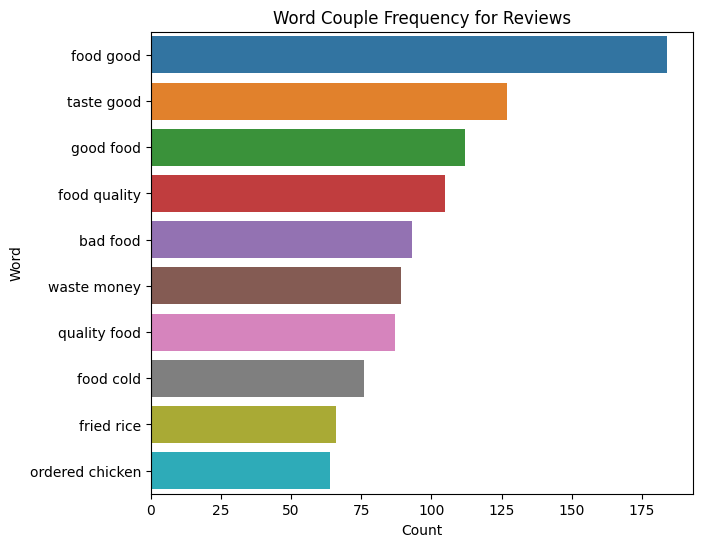

In [11]:
def get_top_words(column, top_nu_of_words, nu_of_word):

    vec = text.CountVectorizer(ngram_range= nu_of_word, stop_words='english')
    bag_of_words = vec.fit_transform(column)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_nu_of_words]

# Top n word frequencies for reviews
n = 10  # no. of words
lst = get_top_words(df['preprocessed_text'], n, (2,2))
df_words = pd.DataFrame(lst, columns=['Word', 'Count'])
plt.figure(figsize=(7,6))
sns.barplot(data=df_words, x='Count', y='Word')
plt.title('Word Couple Frequency for Reviews');
plt.show()

## **Recomandations**

In [12]:
df_review = df[['restaurant','city','preprocessed_text','sentiment','mean_rating']]
df_review.set_index('restaurant', inplace=True)
indices = pd.Series(df_review.index)

# Creating tf-idf matrix
tfidf = text.TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0.0, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_review['preprocessed_text'])

# Consine Similarities
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [13]:
def recommend(name, cosine_similarities = cosine_similarities):

    recommend_restaurant = []

    # Find the index of the hotel entered
    idx = indices[indices == name].index[0]

    # Find the restaurants with a similar cosine-sim value and order them from bigges number
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)

    # Extract top 30 restaurant indexes with a similar cosine-sim value
    top30_indexes = list(score_series.iloc[0:31].index)

    # Names of the top 30 restaurants
    for each in top30_indexes:
        recommend_restaurant.append(list(df_review.index)[each])

    # Creating the new data set to show similar restaurants
    df_new = pd.DataFrame(columns=['city', 'mean_rating', 'sentiment'])

    # Create the top 30 similar restaurants with some of their columns
    for each in recommend_restaurant:
        # df_new = df_new.append(pd.DataFrame(df_review[['city', 'mean_rating', 'sentiment']][df_review.index == each].sample()))
        df_new = pd.concat([df_new,pd.DataFrame(df_review[['city', 'mean_rating', 'sentiment']][df_review.index == each].sample())], ignore_index=False)

    # Drop the same named restaurants and sort only the top 10 by the highest rating
    df_new = df_new.drop_duplicates(subset=['city', 'mean_rating', 'sentiment'], keep=False)
    df_new = df_new.sort_values(by='mean_rating', ascending=False).head(5)

    print('TOP %s RESTAURANTS LIKE %s WITH SIMILAR REVIEWS: ' % (str(len(df_new)), name))

    return df_new

In [14]:
recommend('Kacchi Bhai - Dhanmondi')

TOP 5 RESTAURANTS LIKE Kacchi Bhai - Dhanmondi WITH SIMILAR REVIEWS: 


,city,mean_rating,sentiment
Chinese Palace,Comilla,3.51,Positive
Tasty Treat - Shahi Eidgah,Sylhet,3.44,Negative
The Burgers Point,Sylhet,3.35,Negative
Chefs Squad,Sylhet,3.12,Negative
Hungry Station,Sylhet,3.05,Negative


In [15]:
recommend('Barcode Cafe_Chittagong')

TOP 5 RESTAURANTS LIKE Barcode Cafe_Chittagong WITH SIMILAR REVIEWS: 


,city,mean_rating,sentiment
Khulna Grand Darbar Restaurant & Party Center,Comilla,3.62,Negative
Burger Xpress - Wari,Dhaka,3.02,Negative
North Burg,Rajshahi,2.91,Negative
Panshi Restaurant,Sylhet,2.87,Negative
Barcode Premium Kebab,Chittagong,2.75,Negative


## **Recommned Restaurant By locations**

In [16]:
def recommend_by_location(name, cosine_similarities=cosine_similarities):
    recommend_restaurant = []

    # Get city of the input restaurant (first occurrence only)
    try:
        input_city = df_review.loc[name].iloc[0]['city'] if isinstance(df_review.loc[name], pd.DataFrame) else df_review.loc[name]['city']
    except KeyError:
        print(f"Restaurant '{name}' not found in the dataset.")
        return pd.DataFrame()

    # Find the index of the restaurant
    idx = indices[indices == name].index[0]

    # Get top cosine similarity scores
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)

    # Extract top similar restaurant indexes (excluding the input one itself)
    top_indexes = list(score_series.iloc[1:51].index)  # skip input itself

    # Get restaurant names
    for i in top_indexes:
        recommend_restaurant.append(df_review.index[i])

    # Build the dataframe with city filtering
    df_new = pd.DataFrame(columns=['city', 'mean_rating', 'sentiment'])

    for rest in recommend_restaurant:
        try:
            city_of_rest = df_review.loc[rest].iloc[0]['city'] if isinstance(df_review.loc[rest], pd.DataFrame) else df_review.loc[rest]['city']
            if city_of_rest == input_city:
                df_temp = df_review[['city', 'mean_rating', 'sentiment']].loc[[rest]].drop_duplicates()
                df_new = pd.concat([df_new, df_temp])
        except KeyError:
            continue

    # Finalize: sort by rating
    df_new = df_new.sort_values(by='mean_rating', ascending=False).head(5)

    print(f"TOP {len(df_new)} RESTAURANTS IN {input_city.upper()} SIMILAR TO '{name}':")
    return df_new


In [17]:
recommend_by_location("Kacchi Bhai - Dhanmondi")


TOP 5 RESTAURANTS IN DHAKA SIMILAR TO 'Kacchi Bhai - Dhanmondi':


,city,mean_rating,sentiment
Cooper's - Lake Drive (Uttara),Dhaka,4.20,Negative
Cooper's - Lake Drive (Uttara),Dhaka,4.20,Positive
Coffee Time - Bailey Road,Dhaka,3.11,Positive
Coffee Time - Bailey Road,Dhaka,3.11,Negative
Burger Xpress - Wari,Dhaka,3.02,Negative


In [18]:
recommend_by_location('Barcode Cafe_Chittagong')

TOP 2 RESTAURANTS IN CHITTAGONG SIMILAR TO 'Barcode Cafe_Chittagong':


,city,mean_rating,sentiment
Barcode Premium Kebab,Chittagong,2.75,Negative
Barcode Premium Kebab,Chittagong,2.75,Positive
